# tensors

> A lovely way to display Pytorch tensors

In [ ]:
#| default_exp tensors

In [ ]:
#| hide
#| export
from typing import Optional

from PIL import Image
import torch
from nbdev.showdoc import *
from fastcore.test import test_eq
from fastcore.foundation import patch_to

# import wandb

In [ ]:
# |hide
# |exporti
class __PrinterOptions(object):
    precision: int = 3
    threshold_max: int = 3 # .abs() larger than 1e3 -> Sci mode
    threshold_min: int = -4 # .abs() smaller that 1e-4 -> Sci mode
    sci_mode: Optional[bool] = None # None = auto. Otherwise, force sci mode.
    color: bool = True # Now in color

PRINT_OPTS = __PrinterOptions()

In [ ]:
# |hide
# |exporti
# Do we want this float in decimal or scientific mode?
def sci_mode(f: float):
    return (abs(f) < 10**(PRINT_OPTS.threshold_min) or
            abs(f) > 10**PRINT_OPTS.threshold_max)

In [ ]:
# |hide

test_eq(sci_mode(1.), False)
test_eq(sci_mode(0.00001), True)
test_eq(sci_mode(10000000), True)

# It would be fine either way, both `e` and `f` formats handle those.
test_eq(sci_mode(float('nan')), False)
test_eq(sci_mode(float('inf')), True) 

In [ ]:
# |hide

# What's happening in the cell below
fmt = f"{{:.{4}{'e'}}}"
fmt, fmt.format(1.23)

('{:.4e}', '1.2300e+00')

A slightly better way to print `float` values.

In [ ]:
# |export

# Convert a tensor into a string.
# This only looks good for small tensors, which is how it's intended to be used.
def tensor_str(t: torch.Tensor):
    if t.dim() == 0:
        v = t.item()
        if t.is_floating_point():
            if not t.is_nonzero():
                return "0."

            sci = (PRINT_OPTS.sci_mode or
                    (PRINT_OPTS.sci_mode is None and sci_mode(v)))

            # The f-string will generate something like "{.4f}", which is used
            # to format the value.
            return f"{{:.{PRINT_OPTS.precision}{'e' if sci else 'f'}}}".format(v)
        else:
            return '{}'.format(v) # Should we use sci mode for large ints too?
    else:
        slices = [tensor_str(t[i]) for i in range(0, t.size(0))]
        return '[' + ", ".join(slices) + ']'

In [ ]:
# |hide
torch.manual_seed(42)
randoms = torch.randn(100)

In [ ]:
# |hide
t = randoms[:12].clone()

t[0] *= 10000
t[1] /= 10000
t[3] = float('inf')
t[4] = float('-inf')
t[5] = float('nan')
t = t.reshape((2,6))


In [ ]:
tensor_str(t)

'[[1.927e+04, 0.000, 0.901, inf, -inf, nan], [-0.043, -1.605, -0.752, 1.649, -0.392, -1.404]]'

In [ ]:
# |hide
test_eq(tensor_str(t), '[[1.927e+04, 0.000, 0.901, inf, -inf, nan], [-0.043, -1.605, -0.752, 1.649, -0.392, -1.404]]')

In [ ]:
# |exporti
# |hide
def space_join(lst):
    # Join non-empty list elements into a space-sepaeated string
    return " ".join( [ l for l in lst if l] )

In [ ]:
# |hide
test_eq(space_join(["Hello", None, "World"]), 'Hello World')

In [ ]:
#| export

@torch.no_grad()
def lovely(t: torch.Tensor, verbose=False, plain=False):
    if plain:
        return torch._tensor_str._tensor_str(t, indent=0)

    tname = "tensor" if type(t) in [torch.Tensor, torch.nn.Parameter] else type(t).__name__

    grad_fn = "grad_fn" if t.grad_fn else None
    # All tensors along the compute path actually have required_grad=True. Torch __repr__ just dones not show it.
    grad = "grad" if not t.grad_fn and t.requires_grad else None

    shape = str(list(t.shape))

    zeros = "all_zeros" if not t.count_nonzero() else None
    pinf = "+inf!" if t.isposinf().any() else None
    ninf = "-inf!" if t.isneginf().any() else None
    nan = "nan!" if t.isnan().any() else None

    attention = space_join([zeros,pinf,ninf,nan])

    x, summary = "", ""
    if not zeros:
        x = "x=" + (tensor_str(t) if t.numel() <= 10 else "...")

        # Make sure it's float32. Also, we calculate stats on good values only.
        ft = t.float()[  torch.isfinite(t) ]

        minmax = f"x∈[{tensor_str(ft.min())}, {tensor_str(ft.max())}]" if t.numel() > 2 and ft.numel() > 2 else None
        meanstd = f"μ={tensor_str(ft.mean())} σ={tensor_str(ft.std())}" if t.numel() >= 2 and ft.numel() >= 2 else None
        numel = f"n={t.numel()}" if t.numel() > 5 else None

        summary = space_join([numel, minmax, meanstd])

    dtnames = { torch.float32: "",
                torch.float16: "fp16",
                torch.float64: "fp64",
                torch.uint8: "u8",
                torch.int32: "i32",
             }

    dtype = dtnames[t.dtype] if t.dtype in dtnames else str(t.dtype)[6:]
    dev = str(t.device) if t.device.type != "cpu" else None

    res = tname + space_join([shape,summary,dtype,grad,grad_fn,dev,attention]) 
    return res + ("\nx=" + torch._tensor_str._tensor_str(t, indent=2) if verbose else " "+x)


Would be _lovely_ if you could see all the important tensor stats too?

In [ ]:
t0,t1,t2,t3 = randoms[0], randoms[:2], randoms[:6].view(2, 3), randoms[:11]

print(lovely(t0))
print(lovely(t1))
print(lovely(t2)) # More than 2 elements -> show statistics
print(lovely(t3)) # More than 10 -> suppress data output

tensor[] x=1.927
tensor[2] μ=1.707 σ=0.311 x=[1.927, 1.487]
tensor[2, 3] n=6 x∈[-2.106, 1.927] μ=0.276 σ=1.594 x=[[1.927, 1.487, 0.901], [-2.106, 0.678, -1.235]]
tensor[11] n=11 x∈[-2.106, 1.927] μ=0.046 σ=1.384 x=...


In [ ]:
# |hide
test_eq(lovely(t0), "tensor[] x=1.927")
test_eq(lovely(t1), "tensor[2] μ=1.707 σ=0.311 x=[1.927, 1.487]")
test_eq(lovely(t2), "tensor[2, 3] n=6 x∈[-2.106, 1.927] μ=0.276 σ=1.594 x=[[1.927, 1.487, 0.901], [-2.106, 0.678, -1.235]]")
test_eq(lovely(t3), "tensor[11] n=11 x∈[-2.106, 1.927] μ=0.046 σ=1.384 x=...")

In [ ]:
grad = torch.tensor(1., requires_grad=True)
print(lovely(grad)); print(lovely(grad+1))


tensor[] grad x=1.000
tensor[] grad_fn x=2.000


In [ ]:
# |hide
test_eq(lovely(grad), "tensor[] grad x=1.000")
test_eq(lovely(grad+1), "tensor[] grad_fn x=2.000")

In [ ]:
if torch.cuda.is_available():
    print(lovely(torch.tensor(1., device=torch.device("cuda:0"))))
    test_eq(lovely(torch.tensor(1., device=torch.device("cuda:0"))), "tensor[] cuda:0 x=1.000")

tensor[] cuda:0 x=1.000


In [ ]:
class TestClass(torch.Tensor): pass

lovely(TestClass([1.]))

'TestClass[1] x=[1.000]'

Do we have __any__ floating point nasties? Is the tensor __all__ zeros?

> Statistics and range are calculated on good values only, if there are at lest 3 of them.

In [ ]:
print(lovely(t))
print(lovely(torch.zeros(12)))
print(lovely(torch.tensor([float("nan")]*11)))

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan! x=...
tensor[12] all_zeros 
tensor[11] n=11 nan! x=...


In [ ]:
torch.set_printoptions(linewidth=120)

print("Verbose:")
print(lovely(t, verbose=True))
print("\nPlain:")
print(lovely(t, plain=True))

Verbose:
tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!
x=[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
   [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

Plain:
[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
 [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]


Would be lovely if we did not have to call the function explicitly.

Let's monkey-patch `torch.Tensor` itself!

In [ ]:
in_stats = { "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225) }
numbers = torch.load("mysteryman.pt")

In [ ]:
# |export
def show_rgb(t: torch.Tensor, denorm=None):
    t = t.cpu().clone().squeeze()
    if t.dim() == 3 and t.shape[0] == 3:
        # Looks like an RGB image

        means = torch.tensor(denorm["mean"] if denorm else (0., 0., 0.,))
        stds = torch.tensor(denorm["std"] if denorm else (1., 1., 1.,))


        assert means.shape == stds.shape == (3,)
        return Image.fromarray((t.permute(1, 2, 0) * stds + means).mul(255).byte().numpy())

    return None

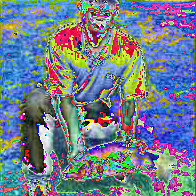

In [ ]:
show_rgb(numbers)


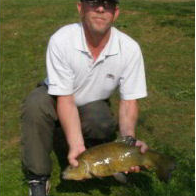

In [ ]:
show_rgb(numbers, denorm=in_stats)

In [ ]:
# |export
def monkey_patch(cls=torch.Tensor):
    "Monkey-patch lovely features into `cls`" 

    @patch_to(cls)
    def __repr__(t: torch.Tensor, *, tensor_contents=None):
        plain = hasattr(t, "_lovely_plain") and t._lovely_plain
        verbose = hasattr(t, "_lovely_verbose") and t._lovely_verbose
        return lovely(t, plain=plain, verbose=verbose)

    def styled_tensor(t: torch.Tensor, tensor_contents, style):
        assert style in ["plain", "verbose"]
        t = tensor_contents if tensor_contents is not None else t
        t = t.view(t.shape)
        setattr(t, "_lovely_" + style, True)
        return t

    # Keep an esiy way to get the standard behavior.
    @patch_to(cls, as_prop=True)
    def plain(t: torch.Tensor, *, tensor_contents=None):
        return styled_tensor(t, tensor_contents, "plain")

    # And a verbose option for a good measure.
    @patch_to(cls, as_prop=True)
    def verbose(t: torch.Tensor, *, tensor_contents=None):
        return styled_tensor(t, tensor_contents, "verbose")

    @patch_to(cls, as_prop=True)
    def rgb(t: torch.Tensor):
        denorm=t.denorm if hasattr(t, "denorm") else None
        return show_rgb(t, denorm=denorm)


In [ ]:
monkey_patch()

In [ ]:
t

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan! x=...

In [ ]:
t.plain

[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
 [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

In [ ]:
t.verbose

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!
x=[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
   [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

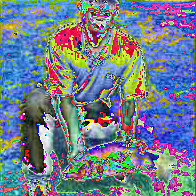

In [ ]:
numbers.rgb

In [ ]:
numbers.denorm=in_stats

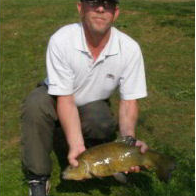

In [ ]:
numbers.rgb

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()